In [1]:
import sys 
path_project = '/home/danshach/pot_store/beegfs_scratch/Xalantir'
sys.path.insert(1, path_project)
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib import patches
from glob import glob
import re

In [3]:
runs_map = {
	'morphology': [['radius'], ['radius'], ['distance']],
	'algorithm': ['mlp2', 'cnn2', 'mlp2'],
    'id_runs': [[1,3],[1],[1]]}
runs_map_df = pd.DataFrame(runs_map)
path_results = path_project + '/results/'
results_round_mode = 'best' # 'average'


In [2]:
runs_map = {
	'morphology': [['radius'], ['radius'], ['distance']],
	'algorithm': ['mlp2', 'cnn2', 'mlp2'],
    'id_runs': [['29'],['5'],['3']]}
runs_map_df = pd.DataFrame(runs_map)


In [23]:
class Run:
    def __init__(self, run, run_id):
        self.morphology = run.morphology
        self.algorithm = run.algorithm
        self.id = run_id
        self.folder =  path_project + '/results/' + '_'.join(self.morphology) + '/' + self.algorithm + '/run_' + self.id
        self.get_results_round(mode='acc_validation')
            
    def get_results_round(self, mode):
        model_scores = pd.read_csv(self.folder + '/model_scores.csv')
        best_round = model_scores.expected_MSE.idxmin()
        self.folder += '/round_' + str(best_round)
    
    def get_simulation_prediction_values(self, morphology):
        file_path = self.folder + '/' + morphology + '_predictions_test_sim.csv'
        df = pd.read_csv(file_path, index_col=0)
        return df
    
    def get_experiment_prediction_values(self, morphology):
        tests = {}
        test_experiment_files = self.folder + '/' + morphology + '_predictions_test_experiment_*.csv' 
        test_experiment_files = glob(test_experiment_files)
        find_test_name_in_pattern = re.compile(r'experiment_(.*?)\.csv')
        for file_path in test_experiment_files:
            test_name = find_test_name_in_pattern.search(file_path).group(1)
            df = pd.read_csv(file_path, index_col=0)
            tests[test_name] = df
        return tests

In [63]:
def darken_color(hex_color, factor=0.3):
    """ darkens the given hex color by blending with black """
    rgb = matplotlib.colors.hex2color(hex_color)
    darkened_rgb = [(1 - factor) * c for c in rgb]
    return matplotlib.colors.to_hex(darkened_rgb)

class Evaluation_Results:
    def __init__(self, runs_map_df):
        self.runs_map = runs_map_df
        self.runs = self.get_runs()
    
    def get_runs(self):
        runs = []
        for i in range(len(self.runs_map)):
            trial = self.runs_map.loc[i]
            for run_id in trial.id_runs:
                run = Run(run=trial, run_id=run_id)
                runs.append(run)
        return runs
    
    # single_plots :: if Fals, runs with same morphology will be ploted on same figure,
    # single_experiments :: if False experiments with same morphology will be ploted on same figure,
    def plot_simulation_predictions(self, runs=None, single_plots=True, save=False):
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        if not runs: runs = self.runs
        # gather all data for plots
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_simulation_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                runs_prediction_values[morphology][run.id] = {
                    'algorithm': run.algorithm,
                    'max_weight': prediction_values['max'].to_numpy(), 
                    'expected': prediction_values['avg'].to_numpy(),
                    'ground_truth': prediction_values['gt'].to_numpy()
                    }
        for morphology, run_data in runs_prediction_values.items():
            plt.figure(figsize=(10, 6)) 
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            if morphology == 'radius':
                min_scope = 1.5#2.5#
                max_scope = 7.5#7.1#
                plt.fill_between(np.arange(len(next(iter(run_data.values()))['max_weight'])),min_scope,max_scope,facecolor='gray', alpha=0.6, label='Training scope')
            if single_plots:
                for run_id, values in run_data.items():
                    x = np.arange(len(values['max_weight']))
                    plt.plot(x, values['expected'], label='expected', marker='.', color='green')
                    plt.plot(x, values['max_weight'], label='max_weight', marker='.', color='red', alpha=0.5)
                    plt.plot(x, values['ground_truth'], label='ground_truth', marker='.', color='k')
                    plt.legend(loc='upper left')
                    plt.xlabel('simulation Nr.')
                    plt.ylabel(morphology + ' (nm)')
                    plt.title(f'Comparison of prediction for {values["algorithm"]}, run: {run_id}') 
                    if save:
                        plt.savefig(f'plot_{morphology}_{run_id}.png')
                    plt.show() 
            else:
                # Only when all runs have same number of data points!!
                colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)]
                #colors = plt.cm.tab10(np.linspace(0, 1, len(run_data)))
                for idx, (run_id, values) in enumerate(run_data.items()):
                    color = colors[idx]
                    x = np.arange(len(values['max_weight']))
                    plt.plot(x, values['expected'], label=f'expected ({values["algorithm"]}_run_{run_id})', marker='.', linestyle='--', color=color)
                    plt.plot(x, values['max_weight'], label=f'max_weight ({values["algorithm"]}_run_{run_id})', marker='.', linestyle=':', color=color, alpha=0.7)
                    plt.plot(x, values['ground_truth'], label=f'ground_truth ({values["algorithm"]}_run_{run_id})', marker='.', linestyle='-', color=darken_color(color))
                #plt.plot(x, list(run_data.values())[0]['ground_truth'], label='ground_truth', marker='.', color='k', linewidth=2)                plt.legend(loc='upper left')
                plt.xlabel('Simulation Nr.')
                plt.ylabel(morphology)
                plt.title(f'Comparison of predictions for morphology: {morphology}')
                plt.legend(loc='upper left')
                if save:
                    plt.savefig(f'plot_{morphology}_combined.png')
                plt.show()
    
    def plot_experiment_predictions(self, runs=None, single_plots=True, single_experiments=False, save=False):
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        if not runs: runs = self.runs
        # gather all data for plots
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_experiment_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                for measurement in prediction_values:
                    # if measurement not in runs_prediction_values[morphology][run.id]:
                    #     runs_prediction_values[morphology][run.id][measurement] = {}
                    if run.id not in runs_prediction_values[morphology]:
                         runs_prediction_values[morphology][run.id] = {}
                    runs_prediction_values[morphology][run.id][measurement] = {
                        'algorithm': run.algorithm,
                        'max_weight': prediction_values[measurement]['max'].to_numpy(), 
                        'expected': prediction_values[measurement]['avg'].to_numpy(),
                        'ground_truth': prediction_values[measurement]['gt'].to_numpy(),
                        'thickness': prediction_values[measurement]['thickness'].to_numpy()
                        }
        for morphology, runs in runs_prediction_values.items():
            colors = [matplotlib.colors.to_hex(plt.cm.Dark2(i)) for i in range(10)] 

            if single_plots:
                for run_id, measurements in runs.items():
                    if single_experiments:
                        for measurement, values in measurements.items():
                            plt.figure(figsize=(10, 6))
                            x = values['thickness']
                            plt.plot(x, values['expected'], label='Expected', marker='.', color='green')
                            plt.plot(x, values['max_weight'], label='Max Weight', marker='.', color='orange', alpha=0.5)
                            plt.plot(x, values['ground_truth'], label='Ground Truth', marker='.', color='k')
                            plt.legend(loc='upper left')
                            plt.xlabel('Layer Thickness (nm)')
                            plt.ylabel(morphology + ' (nm)')
                            plt.title(f'{values["algorithm"]} - {morphology} - {run_id} - {measurement}')
                            self.fill_between(x, morphology)                            
                            if save:
                                plt.savefig(f'{morphology}_{run_id}_{measurement}.png')
                            plt.show()
                    else:
                        plt.figure(figsize=(10, 6))
                        # x = next(iter(measurements.values()))['thickness']
                        xs = []
                        for idx, (measurement, values) in enumerate(measurements.items()):
                            x = values['thickness']
                            if len(x)>len(xs): xs = x
                            plt.plot(x, values['expected'], label=f'{measurement} Expected', marker='.',markersize=0.5, color=colors[idx])
                            plt.plot(x, values['max_weight'], label=f'{measurement} Max Weight', marker='.',markersize=0.5, alpha=0.5, color=colors[idx])
                            plt.plot(x, values['ground_truth'], label=f'{measurement} Ground Truth', marker='.', color=darken_color(colors[idx]))
                        plt.legend(loc='upper left')
                        plt.xlabel('Layer Thickness (nm)')
                        plt.ylabel(morphology + ' (nm)')
                        plt.title(f'{morphology} - {run_id}')
                        
                        self.fill_between(xs, morphology)
                        if save:
                            plt.savefig(f'{morphology}_{run_id}.png')
                        plt.show()
            else:
                for measurement in next(iter(runs.values())).keys():
                    plt.figure(figsize=(10, 6))
                    x = next(iter(runs.values()))[measurement]['thickness']
                    for idx, (run_id, measurements) in enumerate(runs.items()):
                        values = measurements[measurement]
                        plt.plot(x, values['expected'], label=f'{values["algorithm"]} - {run_id} Expected', marker='.',markersize=0.5, color=colors[idx])
                        plt.plot(x, values['max_weight'], label=f'{values["algorithm"]} - {run_id} Max Weight', marker='.',linestyle='--', alpha=0.6,markersize=0.5, color=colors[idx])
                        if idx==0:
                            plt.plot(x, values['ground_truth'], label=f'Ground Truth', marker='.',markersize=1.0, color='k')
                    plt.legend(loc='upper left')
                    plt.xlabel('Layer Thickness (nm)')
                    plt.ylabel(morphology + ' (nm)')
                    plt.title(f'{measurement}')
                    self.fill_between(x, morphology)
                    if save:
                        plt.savefig(f'{morphology}_{measurement}.png')
                    plt.show()

    def plot_real_predictions(self, runs=None, single_plots=True):
        pass

    def plot_simulation_prediction_2R_to_D(self, runs=None, single_plots=True):
        if not runs: runs = self.runs
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_simulation_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                runs_prediction_values[morphology][run.id] = {
                    'algorithm': run.algorithm,
                    'max_weight': prediction_values['max'].to_numpy(), 
                    'expected': prediction_values['avg'].to_numpy(),
                    'ground_truth': prediction_values['gt'].to_numpy()
                    }
        if ['distance','radius'] not in runs_prediction_values:
            return 0
        plot_values = []
        for run_idr, radius_values in runs_prediction_values['radius'].items():
            for run_idd, distance_values in runs_prediction_values['distance'].items():
                values = {
                    'expected_2R2D': radius_values['expected']*2 / distance_values['expected'],
                    'true_2R2D': radius_values['ground_truth']*2 / distance_values['ground_truth'],
                    'run_id_radius': run_idr,
                    'run_id_distance': run_idd,
                    'algorithm_radius': radius_values['algorithm'],
                    'algorithm_distance': distance_values['algorithm']
                }
                plot_values.append(values)
        if single_plots:
            for values in plot_values:
                pass
    
    def plot_experiment_prediction_2R_to_D(self, runs=None, single_plots=True, single_experiments=False, save=False):
        if not runs: runs = self.runs
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_experiment_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                for measurement in prediction_values:
                    if run.id not in runs_prediction_values[morphology]:
                         runs_prediction_values[morphology][run.id] = {}
                    runs_prediction_values[morphology][run.id][measurement] = {
                        'algorithm': run.algorithm,
                        'max_weight': prediction_values[measurement]['max'].to_numpy(), 
                        'expected': prediction_values[measurement]['avg'].to_numpy(),
                        'ground_truth': prediction_values[measurement]['gt'].to_numpy(),
                        'thickness': prediction_values[measurement]['thickness'].to_numpy()
                        }
        if not all(x in runs_prediction_values.keys() for x in ['distance','radius']):
            return 0
        
        plot_values = {}
        for run_idr, radius_values in runs_prediction_values['radius'].items():
            # print(f'run_idr, radius_values: {run_idr}, {radius_values}')
            for measurement in radius_values:
                if measurement not in plot_values:
                    plot_values[measurement] = []
                for run_idd, distance_values in runs_prediction_values['distance'].items():
                    values = {
                        'thickness': distance_values[measurement]['thickness'],
                        'expected_2R2D': radius_values[measurement]['expected']*2 / distance_values[measurement]['expected'],
                        'true_2R2D': radius_values[measurement]['ground_truth']*2 / distance_values[measurement]['ground_truth'],
                        'run_id_radius': run_idr,
                        'run_id_distance': run_idd,
                        'algorithm_radius': radius_values[measurement]['algorithm'],
                        'algorithm_distance': distance_values[measurement]['algorithm']
                    }
                    plot_values[measurement].append(values)
        for measurement, values_list in plot_values.items():
            if single_plots:
                for values in values_list:
                    plt.figure(figsize=(8, 5))
                    x = values['thickness']
                    plt.plot(x, values['expected_2R2D'], label='expected', color='g',linestyle='-',marker='.',markersize=2)
                    plt.plot(x, values['true_2R2D'], label='ground truth', color='k',linestyle='-',marker='.',markersize=2)
                    plt.ylabel('2R/D')
                    plt.xlabel('layer thickness (nm)')
                    plt.xlim(x.min(),x.max())
                    plt.ylim(0.0,2.0)
                    plt.legend()
                    plt.tight_layout()
                    plt.title(f'2R/D for {measurement}\nradius {values["algorithm_radius"]} - {values["run_id_radius"]}, distance {values["algorithm_distance"]} - {values["run_id_distance"]}')
                    plt.show()
            else:
                colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)] 
                plt.figure(figsize=(8, 5))
                for idx, values in enumerate(values_list):
                    color = colors[idx]
                    x = values['thickness']
                    label_expected = f'Expected R - {values["algorithm_radius"]} - {values["run_id_radius"]}, D - {values["algorithm_distance"]} - {values["run_id_distance"]}'
                    # label_true = f'Ground True R - {values["algorithm_radius"]} - {values["run_id_radius"]}, D - {values["algorithm_distance"]} - {values["run_id_distance"]}'
                    plt.plot(x, values['expected_2R2D'], label=label_expected, color=color, linestyle='-',marker='.',markersize=2)
                plt.plot(x, values['true_2R2D'], label='Ground True', color='k',linestyle='-',marker='.',markersize=2)
                plt.ylabel('2R/D')
                plt.xlabel('layer thickness (nm)')
                plt.xlim(x.min(),x.max())
                plt.ylim(0.0,2.0)
                plt.legend()
                plt.title(f'2R/D for {measurement}')
                if save:
                    plt.savefig(f'{morphology}_{measurement}.png')
                plt.show()
    
    def plot_experiment_prediction_2R_to_D_sidebyside(self, runs=None, single_plots=True, single_experiments=False, save=False):
        """
        Plots the ratio of twice the radius (2R) to the distance (D) for experimental data, 
        comparing predicted and ground truth values.

        Parameters:
        - runs (list): List of runs to plot. If None, uses all runs.
        - single_plots (bool): If True, each plot is displayed separately. If False, combined plots are shown.
        - single_experiments (bool): If True, plots each experiment separately within the same run.
        - save (bool): If True, saves the plots as images.
        """
        if not runs:
            runs = self.runs

        # Gather prediction values
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_experiment_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                for measurement in prediction_values:
                    if run.id not in runs_prediction_values[morphology]:
                        runs_prediction_values[morphology][run.id] = {}
                    runs_prediction_values[morphology][run.id][measurement] = {
                        'algorithm': run.algorithm,
                        'max_weight': prediction_values[measurement]['max'].to_numpy(), 
                        'expected': prediction_values[measurement]['avg'].to_numpy(),
                        'ground_truth': prediction_values[measurement]['gt'].to_numpy(),
                        'thickness': prediction_values[measurement]['thickness'].to_numpy()
                    }

        # Ensure required morphologies are available
        if not all(x in runs_prediction_values.keys() for x in ['distance', 'radius']):
            print("Required morphologies 'radius' and 'distance' are not available in the runs.")
            return

        # Calculate 2R/D ratios
        plot_values = {}
        for run_idr, radius_values in runs_prediction_values['radius'].items():
            for measurement in radius_values:
                if measurement not in plot_values:
                    plot_values[measurement] = []
                for run_idd, distance_values in runs_prediction_values['distance'].items():
                    values = {
                        'thickness': distance_values[measurement]['thickness'],
                        'expected_2R2D': (radius_values[measurement]['expected'] * 2) / distance_values[measurement]['expected'],
                        'true_2R2D': (radius_values[measurement]['ground_truth'] * 2) / distance_values[measurement]['ground_truth'],
                        'run_id_radius': run_idr,
                        'run_id_distance': run_idd,
                        'algorithm_radius': radius_values[measurement]['algorithm'],
                        'algorithm_distance': distance_values[measurement]['algorithm']
                    }
                    plot_values[measurement].append(values)
        # Plotting
        for measurement, values_list in plot_values.items():
            if single_plots:
                for i in range(0, len(values_list), 2):
                    # create side-by-side subplots
                    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
                    for j, ax in enumerate(axes):
                        if i + j < len(values_list):
                            values = values_list[i + j]
                            x = values['thickness']
                            ax.plot(x, values['expected_2R2D'], label='Expected', color='g', linestyle='-', marker='.', markersize=2)
                            ax.plot(x, values['true_2R2D'], label='Ground Truth', color='k', linestyle='-', marker='.', markersize=2)
                            ax.set_ylabel('2R/D')
                            ax.set_xlabel('Layer Thickness (nm)')
                            ax.set_xlim(x.min(), x.max())
                            ax.set_ylim(0.0, 2.0)
                            ax.legend()
                            ax.set_title(
                                f'2R/D for {measurement}\nRadius: {values["algorithm_radius"]} (Run: {values["run_id_radius"]}), '
                                f'Distance: {values["algorithm_distance"]} (Run: {values["run_id_distance"]})'
                            )
                    plt.tight_layout()
                    plt.show()
                    if save:
                        fig.savefig(f'{measurement}_pair_{i//2}.png')
        if not single_plots:
            # Define colors and plot layout
            colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)]
            num_measurements = len(plot_values)
            num_cols = 2  # We want two measurements side by side
            num_rows = (num_measurements + 1) // num_cols  # Compute the number of rows needed

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))
            axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

            # Plot each measurement in its own subplot
            for idx, (measurement, values_list) in enumerate(plot_values.items()):
                ax = axes[idx]
                x = None

                for idv, values in enumerate(values_list):
                    if x is None:
                        x = values['thickness']

                    ax.plot(
                        x, values['expected_2R2D'],
                        label=f'Expected R: {values["algorithm_radius"]} (Run: {values["run_id_radius"]}), '
                              f'D: {values["algorithm_distance"]} (Run: {values["run_id_distance"]})',
                        color=colors[idv % len(colors)], linestyle='-', marker='.', markersize=2
                    )
                    if idv==len(values_list)-1:
                        ax.plot(
                            x, values['true_2R2D'],
                            label='Ground Truth', color='black', linestyle='-', marker='.', markersize=2
                        )

                ax.set_ylabel('2R/D')
                ax.set_xlabel('Layer Thickness (nm)')
                ax.set_xlim(x.min(), x.max())
                ax.set_ylim(0.0, 2.0)
                ax.legend()
                ax.set_title(f'2R/D for {measurement}')

            # Hide any unused subplots
            for idx in range(num_measurements, len(axes)):
                axes[idx].axis('off')

            plt.tight_layout()
            if save:
                plt.savefig('measurements_combined.png')
            plt.show()

                        
    def plot_real_prediction_2R_to_D(self, runs=None, single_plots=True):
        pass
    
    def plot_compare_results_simulation_experiment(self, runs=None, single_plots=True):
        # compare experiment predictions and gt with simulation predictions and ground truth
        pass
    
    def fill_between(self,x, morphology):
        if morphology == 'radius':
            min_scope = 1.5#2.5#
            max_scope = 7.5#7.1#
            plt.ylim((0,14))
        elif morphology == 'distance':
            min_scope = 3.8#2.5#
            max_scope = 15.0#7.1#
            plt.ylim((0,25))
        else: 
            min_scope = 0#2.5#
            max_scope = 0#7.1#
        plt.fill_between(x,min_scope,max_scope,facecolor='gray', alpha=0.6, label='Training scope')

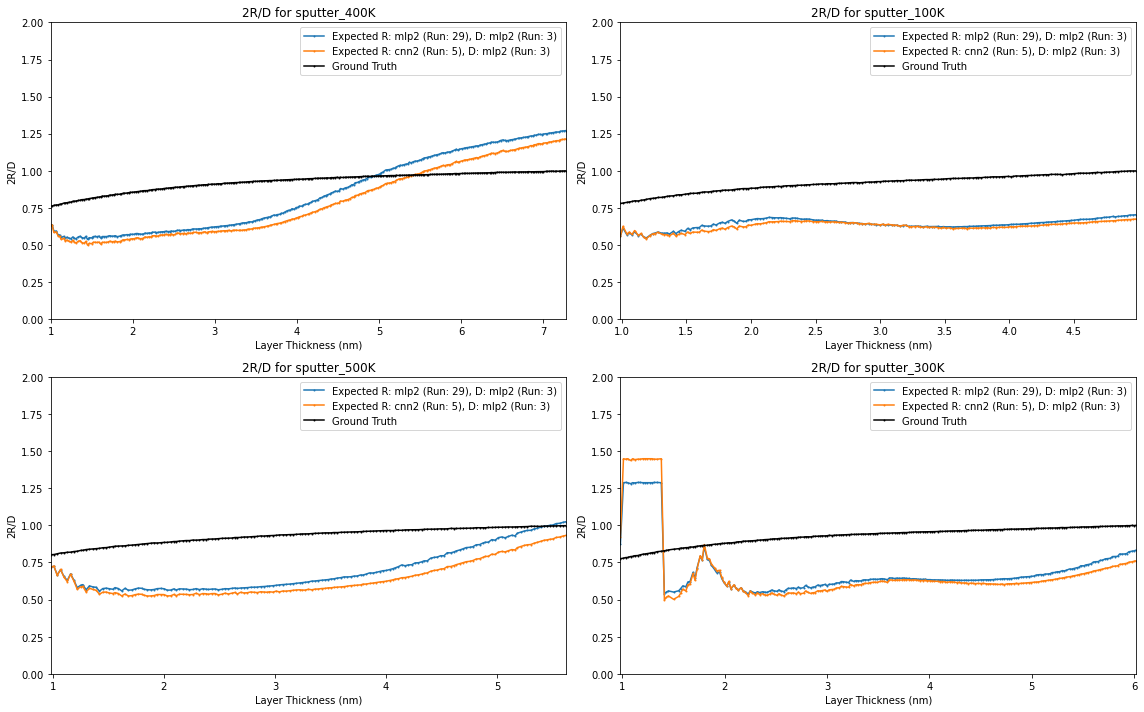

In [64]:
evaluation = Evaluation_Results(runs_map_df)
evaluation.plot_experiment_prediction_2R_to_D_sidebyside(single_plots=False, single_experiments=False)

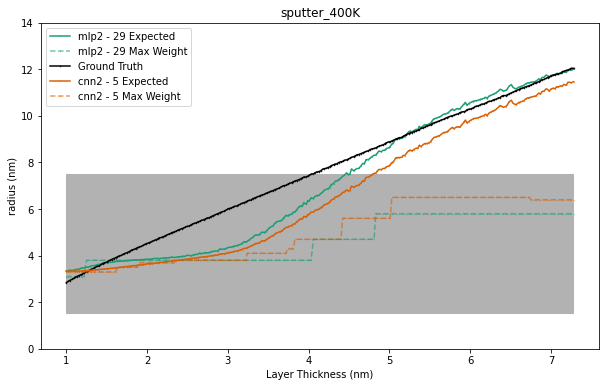

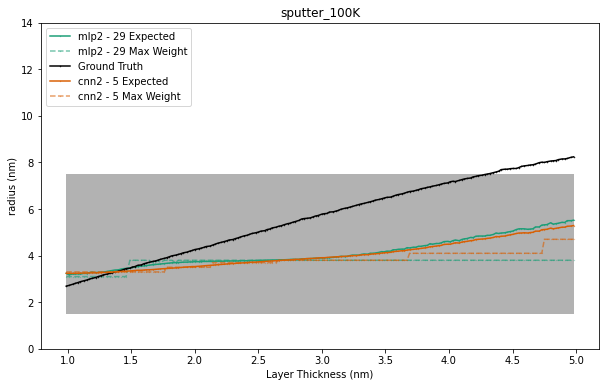

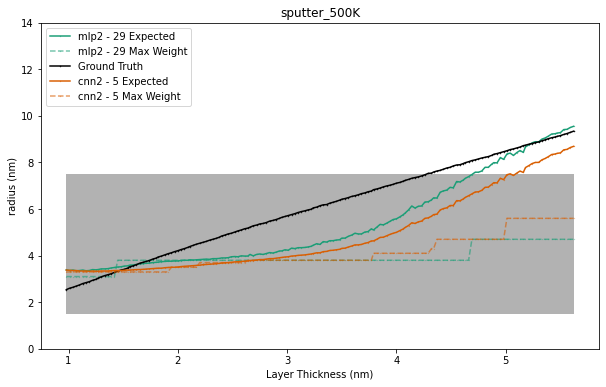

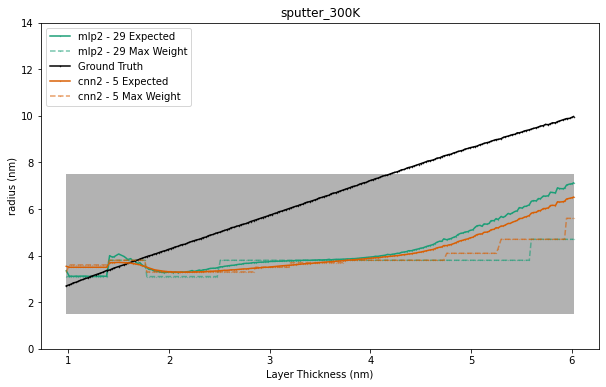

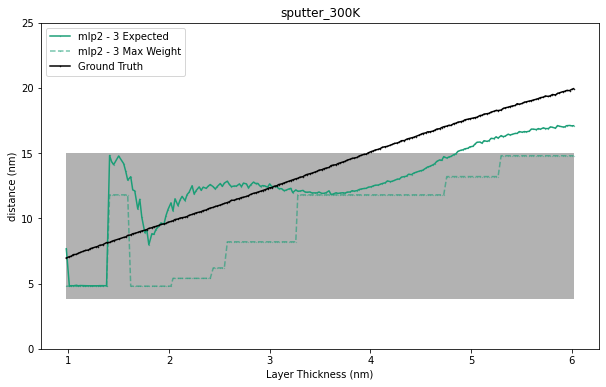

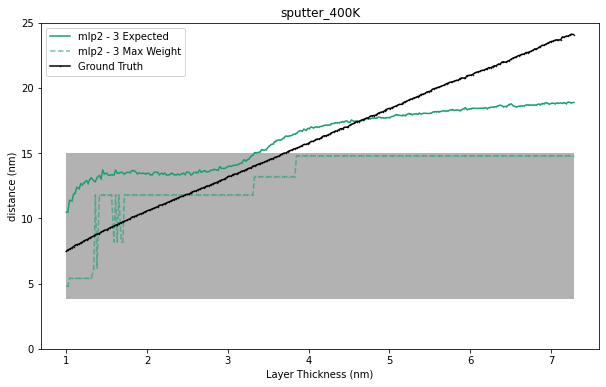

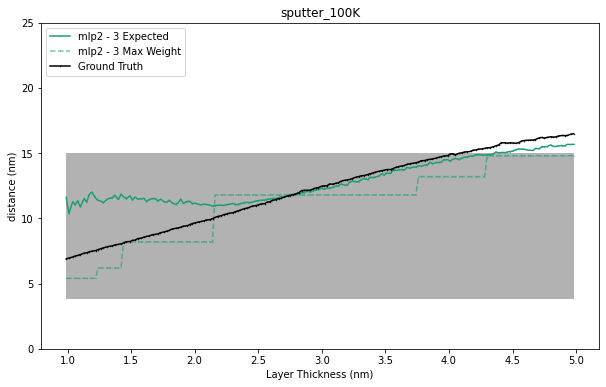

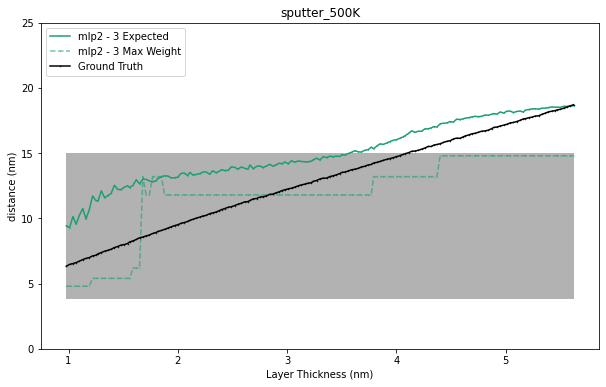

In [65]:
evaluation.plot_experiment_predictions(single_plots=False, single_experiments=False)